In [ ]:
!conda install -c conda-forge rdkit


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [2]:
data = pd.read_csv('data.csv')
data.dropna(axis='index', subset=['pchembl_value'],inplace=True)
data.drop_duplicates(subset=['chembl_id'], keep=False, inplace=True)
data.set_index('chembl_id', inplace=True)
data

,standard_relation,standard_value,standard_type,pchembl_value,canonical_smiles
chembl_id,,,,,
CHEMBL117716,=,44.4,IC50,7.35,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c...
CHEMBL369583,=,1.3,Ki,8.89,CC(=N)N1CCC(Oc2ccc3nc(CCC(=O)O)n(Cc4ccc5ccc(C(...
CHEMBL176744,=,2.0,Ki,8.70,CC(=N)N1CCC(Oc2ccc3c(c2)nc(C(C)C)n3Cc2ccc3ccc(...
CHEMBL367476,=,3.3,Ki,8.48,CCC(C)c1nc2cc(OC3CCN(C(C)=N)CC3)ccc2n1Cc1ccc2c...
CHEMBL366405,=,80.0,Ki,7.10,COC(=O)C(C)CN(c1ccc2c(c1)nc(C)n2Cc1ccc2ccc(C(=...
...,...,...,...,...,...
CHEMBL4292202,=,550.0,Ki,6.26,CC(C)(C)CCCN1C(=O)[C@H]2[C@@H](C1=O)[C@@H]1CCC...
CHEMBL4280061,=,911.0,Ki,6.04,CNCCCN1C(=O)[C@H]2[C@@H](C1=O)[C@@H]1CCCN1[C@H...
CHEMBL4286727,=,9800.0,Ki,5.01,NCCCN1C(=O)[C@H]2[C@@H](C1=O)[C@@H]1CCCN1[C@H]...


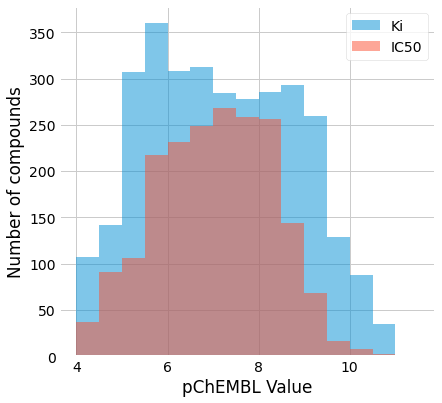

In [3]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
data[(data['standard_type']=='Ki') & (data['standard_relation']=='=')]['pchembl_value'].hist(ax=ax, alpha=0.5, label='Ki', bins=np.arange(4,12,0.5))
data[(data['standard_type']=='IC50') & (data['standard_relation']=='=')]['pchembl_value'].hist(ax=ax, alpha=0.5, label='IC50', bins=np.arange(4,12,0.5))
ax.set_xlabel('pChEMBL Value')
ax.set_ylabel('Number of compounds')
ax.legend(loc='best');

### Drawing molecules using RDKit

In [4]:
import rdkit
from rdkit import Chem

mols = {}
for chembl_id, row in data.iterrows():
    mols[chembl_id] = Chem.MolFromSmiles(row['canonical_smiles'])

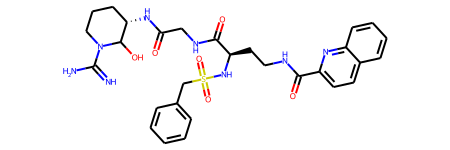

In [5]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mols['CHEMBL117716']

### Descriptor calculation using RDKit

In [6]:
from rdkit.Chem import Descriptors

In [139]:
descriptors = {}

descriptors['n_atoms'] = {chembl_id: Descriptors.HeavyAtomCount(mol) for chembl_id, mol in mols.items()}
descriptors['rotatable_bonds'] = {chembl_id: Descriptors.NumRotatableBonds(mol) for chembl_id, mol in mols.items()}
descriptors['logp'] = {chembl_id: Descriptors.MolLogP(mol) for chembl_id, mol in mols.items()}
descriptors['molecular_weight'] = {chembl_id: Descriptors.ExactMolWt(mol) for chembl_id, mol in mols.items()}
descriptors['hb_donors'] = {chembl_id: Descriptors.NumHDonors(mol) for chembl_id, mol in mols.items()}
descriptors['hb_acceptors'] = {chembl_id: Descriptors.NumHAcceptors(mol) for chembl_id, mol in mols.items()}

descriptors = pd.DataFrame.from_dict(descriptors)

descriptors

,n_atoms,rotatable_bonds,logp,molecular_weight,hb_donors,hb_acceptors
CHEMBL117716,44,12,-0.24843,624.247852,7,8
CHEMBL369583,38,8,4.37944,512.253589,4,6
CHEMBL176744,36,6,5.48564,482.279410,3,5
CHEMBL367476,37,7,5.87574,496.295060,3,5
CHEMBL366405,41,8,4.90736,553.316523,3,7
...,...,...,...,...,...,...
CHEMBL4292202,31,5,5.00310,461.153990,0,6
CHEMBL4280061,29,6,2.78630,434.117939,1,7
CHEMBL4286727,28,5,2.52560,420.102289,1,7
CHEMBL4283525,31,6,3.27310,463.156516,0,6


Let's compute the ligand efficiency for each of our molecules.

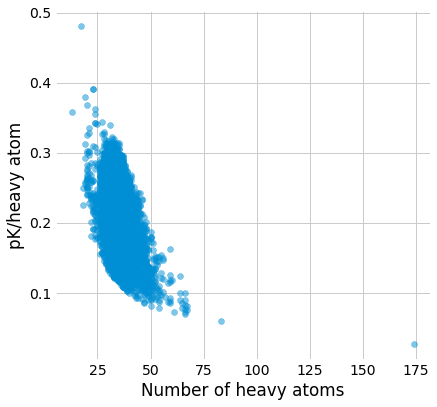

In [8]:
ligand_efficiency = data['pchembl_value'] / descriptors.loc[data.index]['n_atoms']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(descriptors.loc[data.index]['n_atoms'], ligand_efficiency, alpha=0.5)
ax.set_xlabel('Number of heavy atoms')
ax.set_ylabel('pK/heavy atom');

Let's check how many of our molecules have Lipinski RO5 violations.

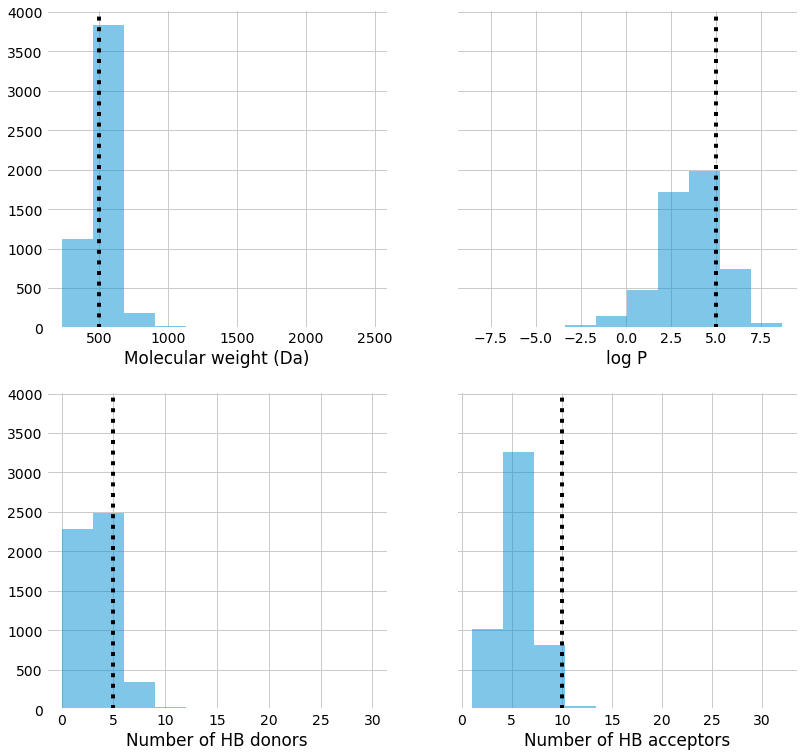

In [9]:
fig, axes = plt.subplots(2,2,figsize=(12,12), sharey=True)
axes = axes.flat
descriptors['molecular_weight'].hist(ax=axes[0], alpha=0.5)
axes[0].axvline(500, color='k', linestyle=':')
axes[0].set_xlabel('Molecular weight (Da)')
descriptors['logp'].hist(ax=axes[1], alpha=0.5)
axes[1].set_xlabel('log P')
axes[1].axvline(5, color='k', linestyle=':')
descriptors['hb_donors'].hist(ax=axes[2], alpha=0.5)
axes[2].set_xlabel('Number of HB donors')
axes[2].axvline(5, color='k', linestyle=':')
descriptors['hb_acceptors'].hist(ax=axes[3], alpha=0.5)
axes[3].set_xlabel('Number of HB acceptors')
axes[3].axvline(10, color='k', linestyle=':');

In [10]:

from argparse import ArgumentParser, Namespace
from io import StringIO
from subprocess import PIPE, Popen, DEVNULL, SubprocessError
from typing import Optional, List

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools, SaltRemover, Descriptors, Lipinski, Crippen, Mol

In [11]:
LIPINSKI_RULES = [
    (descriptors.molecular_weight, 500),
    (descriptors.hb_donors, 5),
    (descriptors.hb_acceptors, 10),
    (descriptors.logp, 5),
]


In [84]:
df = filtering(descriptors)
print(f'After filtering: {len(df)}')


TypeError: 'Series' object is not callable

In [179]:
'''
Lipinski's rules are:
Hydrogen bond donors <= 5
Hydrogen bond acceptors <= 10
Molecular weight < 500 daltons
logP < 5
'''


num_hdonors = descriptors['hb_donors']#descriptors.hb_donors #Lipinski.NumHDonors(mol)
num_hacceptors = descriptors['hb_acceptors']#descriptors.hb_acceptors #Lipinski.NumHAcceptors(mol)
mol_weight = descriptors['molecular_weight'] #descriptors.molecular_weight #Descriptors.MolWt(mol)
mol_logp = descriptors['logp']#descriptors.logp #Crippen.MolLogP(mol)

passed_hdonors = []
failed_hdonors = []

for i in range(len(num_hdonors)):
    
    if num_hdonors[i] > 5:
        failed_hdonors.append(i)    
    else:
        passed_hdonors.append(i)
        
print('Number Hydrogen bond donors over 5:',len(failed_hdonors))



passed_hacceptors = []
failed_hacceptors = []

if num_hacceptors.all() > 10:
    failed_hacceptors.append(i)
else:
    passed_hacceptors.append(i)
    
print('Number Hydrogen acceptors over 10:',len(failed_hacceptors))

num_hacceptors.drop(num_hacceptors.index[failed_hacceptors])


passed_mol_weight = []
failed_mol_weight = []

if mol_weight.all() >= 500:
    failed_mol_weight.append(i)
else:
    passed_mol_weight.append(i)
    
print('Number Molecular weight > 500 daltons:',len(failed_mol_weight))

mol_weight.drop(mol_weight.index[failed_mol_weight])

passed_mol_logp = []
failed_mol_logp = []

if mol_logp.all() >= 5:
    failed_mol_logp.append(i)
else:
    passed_mol_logp.append(i)
    
print('Log partition coefficient over 5:',len(failed_mol_logp))

#mol_logp.drop(mol_logp.index[failed_mol_logp])



Number Hydrogen bond donors over 5: 384
Number Hydrogen acceptors over 10: 0
Number Molecular weight > 500 daltons: 0
Log partition coefficient over 5: 0


In [180]:
# Re build dataframe after filtering 
descriptors.drop(descriptors.index[failed_hdonors])
descriptors

,n_atoms,rotatable_bonds,logp,molecular_weight,hb_donors,hb_acceptors
CHEMBL117716,44,12,-0.24843,624.247852,7,8
CHEMBL369583,38,8,4.37944,512.253589,4,6
CHEMBL176744,36,6,5.48564,482.279410,3,5
CHEMBL367476,37,7,5.87574,496.295060,3,5
CHEMBL366405,41,8,4.90736,553.316523,3,7
...,...,...,...,...,...,...
CHEMBL4292202,31,5,5.00310,461.153990,0,6
CHEMBL4280061,29,6,2.78630,434.117939,1,7
CHEMBL4286727,28,5,2.52560,420.102289,1,7
CHEMBL4283525,31,6,3.27310,463.156516,0,6
